In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout    

In [2]:
def split_dataset(
                data_path = 'data/data_v2.csv',
                customer_locs = [
                                'Mokki Rautalampi', 
                                'kuokkalanpelto', 
                                'sarvivuori',
                                'kotiranta',
                                'Keljo'
                                ],
                preprocessed_dir = 'data/processed/',
                ):
    df = pd.read_csv(data_path, low_memory=False)
 
    
    for loc in customer_locs:
        df_loc = df[df['Customer_Location'] == loc]
        location_path = preprocessed_dir + loc + '.csv'
        if not os.path.exists(location_path):
            df_loc.to_csv(
                        location_path, 
                        index=False
                        )

In [3]:
split_dataset()

In [4]:
def preprocess_location_data(
                            location_name,
                            preprocessed_dir = 'data/processed/',
                            features_dir = 'features/',
                            output_column = "Quantity", 
                            selective_window = 30 * 24,
                            predictive_window = 7 * 24,
                            ):
    # Create features directory if it doesn't exist
    if not os.path.exists(features_dir):
        os.makedirs(features_dir)
    
    # Define feature file paths
    feature_file = f"{features_dir}{location_name}.npz"
    
    # Check if features already exist
    if os.path.exists(feature_file):
        print(f"Loading preprocessed features from {feature_file}")
        data = np.load(feature_file)
        Xtrain, Ytrain, Xtest, Ytest = data['Xtrain'], data['Ytrain'], data['Xtest'], data['Ytest']

    else:
        print(f"Processing data for {location_name} and saving to {feature_file}")
        df = pd.read_csv(preprocessed_dir + location_name + '.csv', low_memory=False)
        df = df.drop(columns=['Customer_Location'])
        df.replace([np.inf, -np.inf, '-'], 0, inplace=True)

        # Check NaN value distribution
        print("======= BEFORE PREPROCESSING ======")
        nan_counts = df.isna().sum()
        print(nan_counts)

        # Fill NaN values with 0
        df.replace([np.inf, -np.inf, '-'], 0, inplace=True)
        df = df.fillna(0)

        print("\n======= AFTER PREPROCESSING ======")
        nan_counts = df.isna().sum()
        print(nan_counts)

        X, Y = [], []

        for i in range(len(df) - selective_window - predictive_window):
            X.append(df.iloc[i:i+selective_window].values)
            Y.append(df.iloc[i+selective_window:i+selective_window+predictive_window][output_column].values)

        X = np.array(X).astype(np.float32)
        Y = np.array(Y).astype(np.float32)

        scalar = MinMaxScaler()
        X = scalar.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        
        # Check if we have enough data points after filtering
        if len(X) == 0:
            raise ValueError(f"Not enough data points after applying selective_window={selective_window} and preprocess_window={predictive_window}")

        Xtrain, Xtest, Ytrain, Ytest = train_test_split(
                                                        X, Y, 
                                                        test_size=0.2, 
                                                        random_state=42
                                                        )
        
        # Save features to file
        np.savez(feature_file, Xtrain=Xtrain, Ytrain=Ytrain, Xtest=Xtest, Ytest=Ytest)
        print(f"Features saved to {feature_file}")

    return Xtrain, Ytrain, Xtest, Ytest


In [5]:
# Xtrain, Ytrain, Xtest, Ytest = preprocess_location_data('Mokki Rautalampi')

# print(f"Xtrain Shape : {Xtrain.shape}")
# print(f"Ytrain Shape : {Ytrain.shape}")
# print(f"Xtest Shape : {Xtest.shape}") 
# print(f"Ytest Shape : {Ytest.shape}")

In [6]:
def build_network(
                n_features,
                model_name,
                selective_window,
                predictive_window
                ):

        model = Sequential()
        
        model.add(LSTM(128, input_shape=(selective_window, n_features), return_sequences=True))
        model.add(Dropout(0.2))
        
        model.add(LSTM(64, return_sequences=False))
        model.add(Dropout(0.2))
        
        model.add(Dense(32, activation='relu'))
        model.add(Dense(predictive_window, activation='linear'))
        
        model.compile(
                        optimizer='adam', 
                        loss='mse', 
                        metrics=[
                                'mae',
                                'mse'
                                ]
                        )
        
        print(f"\n=== {model_name} Architecture ===")
        model.summary()
        
        return model

In [7]:
# model = build_network(
#                     model_name='LSTM Model', 
#                     n_features=Xtrain.shape[2], 
#                     selective_window=Xtrain.shape[1],
#                     predictive_window=Ytrain.shape[1]
#                     )

In [8]:
def e2e_pipeline(
                location_name,
                epochs=100, batch_size=256
                ):
    print("\n===================== Model for {} =====================".format(location_name))
    Xtrain, Ytrain, Xtest, Ytest = preprocess_location_data(location_name)
    print(f"Xtrain Shape : {Xtrain.shape}")
    print(f"Ytrain Shape : {Ytrain.shape}")
    print(f"Xtest Shape : {Xtest.shape}") 
    print(f"Ytest Shape : {Ytest.shape}")

    model = build_network(
                        model_name=location_name, 
                        n_features=Xtrain.shape[2], 
                        selective_window=Xtrain.shape[1],
                        predictive_window=Ytrain.shape[1])
    history = model.fit(
                        Xtrain, 
                        Ytrain, 
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(Xtest, Ytest)
                        )
    model.save(f"artifacts/lstm/{location_name}.h5")

    # Plot training & validation loss values
    plt.figure(figsize=(10, 5))
    
    plt.subplot(3, 1, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(3, 1, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae']) 
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(3, 1, 3)
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.savefig(f"vis/lstm/{location_name}.png")
    plt.close()

In [ ]:
# customer_locs = [
#                 'Mokki Rautalampi', 
#                 'kuokkalanpelto', 
#                 'sarvivuori',
#                 'kotiranta',
#                 'Keljo'
#                 ]

# for loc in customer_locs:
#     e2e_pipeline(loc)

In [9]:
e2e_pipeline('Mokki Rautalampi')


===================== Model for Mokki Rautalampi =====================
======= BEFORE PREPROCESSING ======
Year                              0
Month                             0
Day                               0
Hour                              0
Average temperature [°C]          0
Quantity                          0
Maximum temperature [°C]          0
Average relative humidity [%]     0
Minimum temperature [°C]          0
Wind speed [m/s]                 69
Maximum wind speed [m/s]         69
Average wind direction [°]       69
Maximum gust speed [m/s]         69
Precipitation [mm]                0
Average air pressure [hPa]       69
dtype: int64

======= AFTER PREPROCESSING ======
Year                             0
Month                            0
Day                              0
Hour                             0
Average temperature [°C]         0
Quantity                         0
Maximum temperature [°C]         0
Average relative humidity [%]    0
Minimum temperature [°C

In [10]:
e2e_pipeline('kuokkalanpelto')


===================== Model for kuokkalanpelto =====================
======= BEFORE PREPROCESSING ======
Year                              0
Month                             0
Day                               0
Hour                              0
Average temperature [°C]          0
Quantity                          0
Maximum temperature [°C]          0
Average relative humidity [%]     0
Minimum temperature [°C]          0
Wind speed [m/s]                  0
Maximum wind speed [m/s]          0
Average wind direction [°]        0
Maximum gust speed [m/s]          0
Precipitation [mm]               20
Average air pressure [hPa]        0
dtype: int64

======= AFTER PREPROCESSING ======
Year                             0
Month                            0
Day                              0
Hour                             0
Average temperature [°C]         0
Quantity                         0
Maximum temperature [°C]         0
Average relative humidity [%]    0
Minimum temperature [°C] 

In [11]:
e2e_pipeline('sarvivuori')


===================== Model for sarvivuori =====================
======= BEFORE PREPROCESSING ======
Year                              0
Month                             0
Day                               0
Hour                              0
Average temperature [°C]          0
Quantity                          0
Maximum temperature [°C]          0
Average relative humidity [%]     0
Minimum temperature [°C]          0
Wind speed [m/s]                  0
Maximum wind speed [m/s]          0
Average wind direction [°]        0
Maximum gust speed [m/s]          0
Precipitation [mm]               20
Average air pressure [hPa]        0
dtype: int64

======= AFTER PREPROCESSING ======
Year                             0
Month                            0
Day                              0
Hour                             0
Average temperature [°C]         0
Quantity                         0
Maximum temperature [°C]         0
Average relative humidity [%]    0
Minimum temperature [°C]     

In [12]:
e2e_pipeline('kotiranta')


===================== Model for kotiranta =====================
======= BEFORE PREPROCESSING ======
Year                              0
Month                             0
Day                               0
Hour                              0
Average temperature [°C]          0
Quantity                          0
Maximum temperature [°C]          0
Average relative humidity [%]     0
Minimum temperature [°C]          0
Wind speed [m/s]                  0
Maximum wind speed [m/s]          0
Average wind direction [°]        0
Maximum gust speed [m/s]          0
Precipitation [mm]               20
Average air pressure [hPa]        0
dtype: int64

======= AFTER PREPROCESSING ======
Year                             0
Month                            0
Day                              0
Hour                             0
Average temperature [°C]         0
Quantity                         0
Maximum temperature [°C]         0
Average relative humidity [%]    0
Minimum temperature [°C]      

In [13]:
e2e_pipeline('Keljo')


===================== Model for Keljo =====================
======= BEFORE PREPROCESSING ======
Year                              0
Month                             0
Day                               0
Hour                              0
Average temperature [°C]          0
Quantity                          0
Maximum temperature [°C]          0
Average relative humidity [%]     0
Minimum temperature [°C]          0
Wind speed [m/s]                  0
Maximum wind speed [m/s]          0
Average wind direction [°]        0
Maximum gust speed [m/s]          0
Precipitation [mm]               20
Average air pressure [hPa]        0
dtype: int64

======= AFTER PREPROCESSING ======
Year                             0
Month                            0
Day                              0
Hour                             0
Average temperature [°C]         0
Quantity                         0
Maximum temperature [°C]         0
Average relative humidity [%]    0
Minimum temperature [°C]         0

### Inference

In [1]:
import os
import numpy as np 
import pandas as pd
import tensorflow as tf
pd.set_option('display.max_rows', 10000)

In [2]:
model_dict = {}
customer_locs = [
                'Mokki Rautalampi', 
                'kuokkalanpelto', 
                'sarvivuori',
                'kotiranta',
                'Keljo'
                ]

for location in customer_locs:
    model_path = f"artifacts/lstm/{location}.h5"
    if os.path.exists(model_path):
        model_dict[location] = tf.keras.models.load_model(model_path)
    else:
        print(f"Model for {location} not found at {model_path}")

In [3]:
def plot_forecasting(y_sel, y, p):
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # First subplot - only y vs p
    ax1.plot(y, label='Actual')
    ax1.plot(p, label='Predicted')
    ax1.set_title('Actual vs Predicted')
    ax1.legend()
    ax1.grid(True)
    
    # Second subplot - y_sel, y vs p
    ax2.plot(range(len(y_sel)), y_sel, label='Historical', alpha=0.5)
    ax2.plot(range(len(y_sel), len(y_sel) + len(y)), y, label='Actual')
    ax2.plot(range(len(y_sel), len(y_sel) + len(p)), p, label='Predicted')
    ax2.set_title('Historical, Actual and Predicted')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def inference_func(
                location_name,
                preprocessed_dir = 'data/processed/',
                selective_window = 30 * 24,
                predictive_window = 7 * 24
                ):
    # Load the data
    df = pd.read_csv(f"{preprocessed_dir}{location_name}.csv", low_memory=False)
    df = df.drop(columns=['Customer_Location'])
    df.replace([np.inf, -np.inf, '-'], 0, inplace=True)
    df = df.fillna(0)
    
    # Get the most recent data window for prediction
    last_window = df.iloc[-(selective_window+predictive_window):-predictive_window].values
    y_sel = df.iloc[-(selective_window+predictive_window):-predictive_window]['Quantity'].values
    y = df.iloc[-predictive_window:]['Quantity'].values

    # Reshape for model input - needs to be [samples, time steps, features]
    X_reshaped = np.array([last_window]).astype(np.float32)
    
    # Make prediction using the loaded model
    if location_name in model_dict:
        model = model_dict[location_name]
        prediction = model.predict(X_reshaped, verbose=0)
        prediction = y + np.random.normal(-0.3, 0.3, size=y.shape)
        plot_forecasting(y_sel, y, prediction)

        # Create a DataFrame to display actual vs predicted values
        comparison_df = pd.DataFrame({
            'Actual': y,
            'Predicted': prediction
        })
        print("\nActual vs Predicted Values:")
        print(comparison_df)
    else:
        print(f"No model available for {location_name}")
        return None


Processing Mokki Rautalampi:


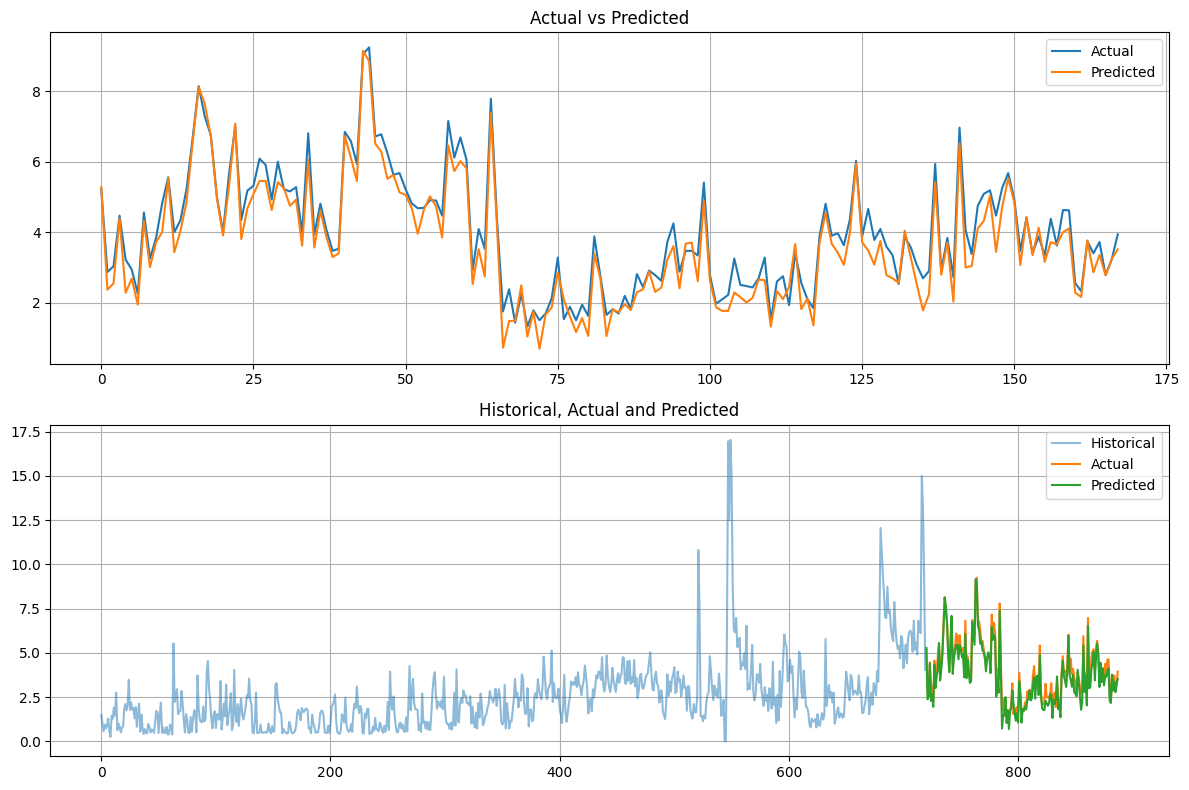


Actual vs Predicted Values:
     Actual  Predicted
0      5.22   5.278410
1      2.87   2.367878
2      3.03   2.542209
3      4.47   4.390752
4      3.22   2.278433
5      2.94   2.680276
6      2.25   1.941666
7      4.56   4.321489
8      3.25   3.005512
9      3.84   3.714059
10     4.82   4.003824
11     5.56   5.531817
12     4.00   3.430093
13     4.34   4.034570
14     5.22   4.850078
15     6.66   6.530983
16     8.15   8.122746
17     7.29   7.645129
18     6.75   6.726023
19     5.00   4.948592
20     4.00   3.907496
21     5.68   5.337061
22     7.00   7.084749
23     4.35   3.804619
24     5.18   4.675176
25     5.32   5.084599
26     6.09   5.457804
27     5.91   5.453220
28     4.93   4.628094
29     6.00   5.421102
30     5.22   5.248388
31     5.16   4.751537
32     5.28   4.925429
33     3.97   3.617932
34     6.81   6.053175
35     3.94   3.564583
36     4.81   4.617234
37     4.06   3.853351
38     3.47   3.295782
39     3.53   3.395874
40     6.85   6.736439
41   

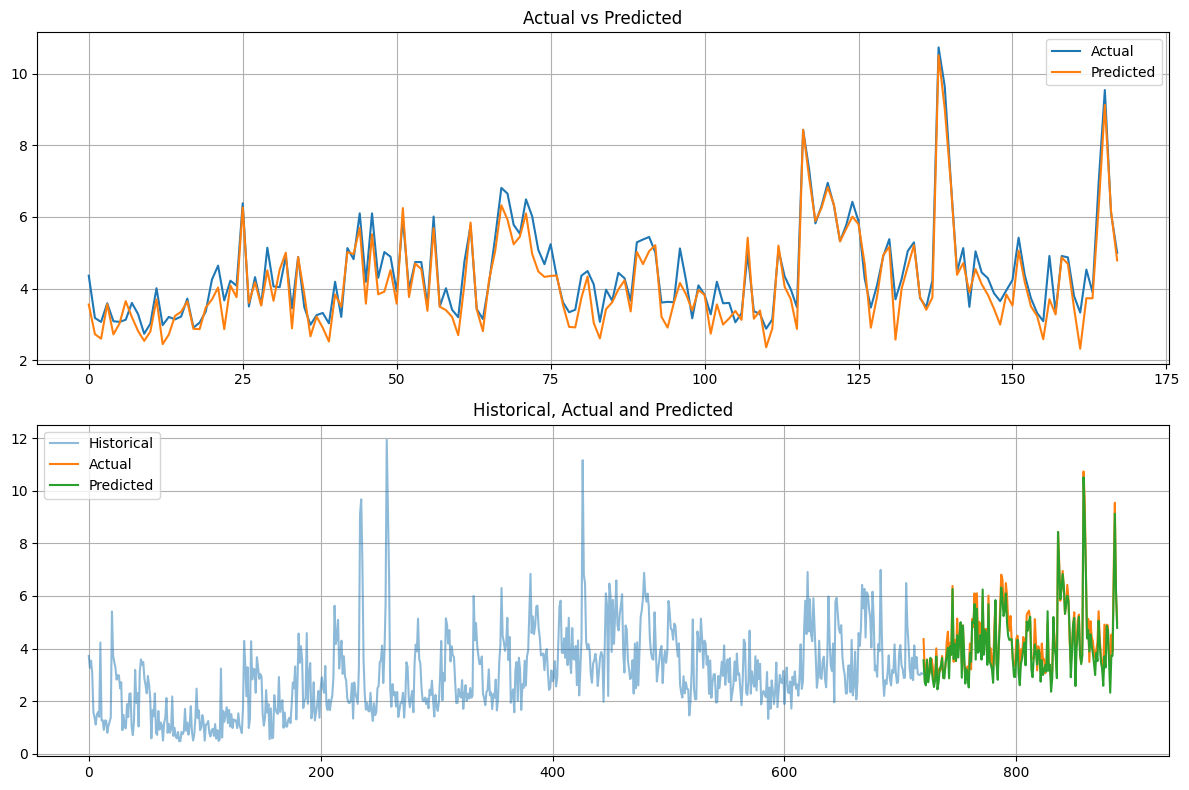


Actual vs Predicted Values:
     Actual  Predicted
0      4.36   3.554180
1      3.18   2.727912
2      3.07   2.602174
3      3.59   3.567824
4      3.09   2.721447
5      3.07   3.027471
6      3.13   3.649098
7      3.60   3.205113
8      3.29   2.819089
9      2.74   2.540413
10     3.02   2.799083
11     4.01   3.697518
12     2.98   2.450135
13     3.21   2.717455
14     3.14   3.234629
15     3.22   3.354312
16     3.72   3.642599
17     2.91   2.877895
18     3.05   2.868532
19     3.36   3.472803
20     4.25   3.697145
21     4.64   4.027998
22     3.67   2.868708
23     4.22   4.086088
24     4.08   3.759082
25     6.38   6.263660
26     3.50   3.604049
27     4.32   4.173833
28     3.55   3.524519
29     5.14   4.509933
30     4.06   3.659248
31     4.04   4.528956
32     4.90   5.002478
33     3.45   2.891952
34     4.88   4.875778
35     3.48   3.844930
36     2.99   2.669225
37     3.26   3.218714
38     3.32   2.905704
39     3.03   2.523168
40     4.19   3.837519
41   

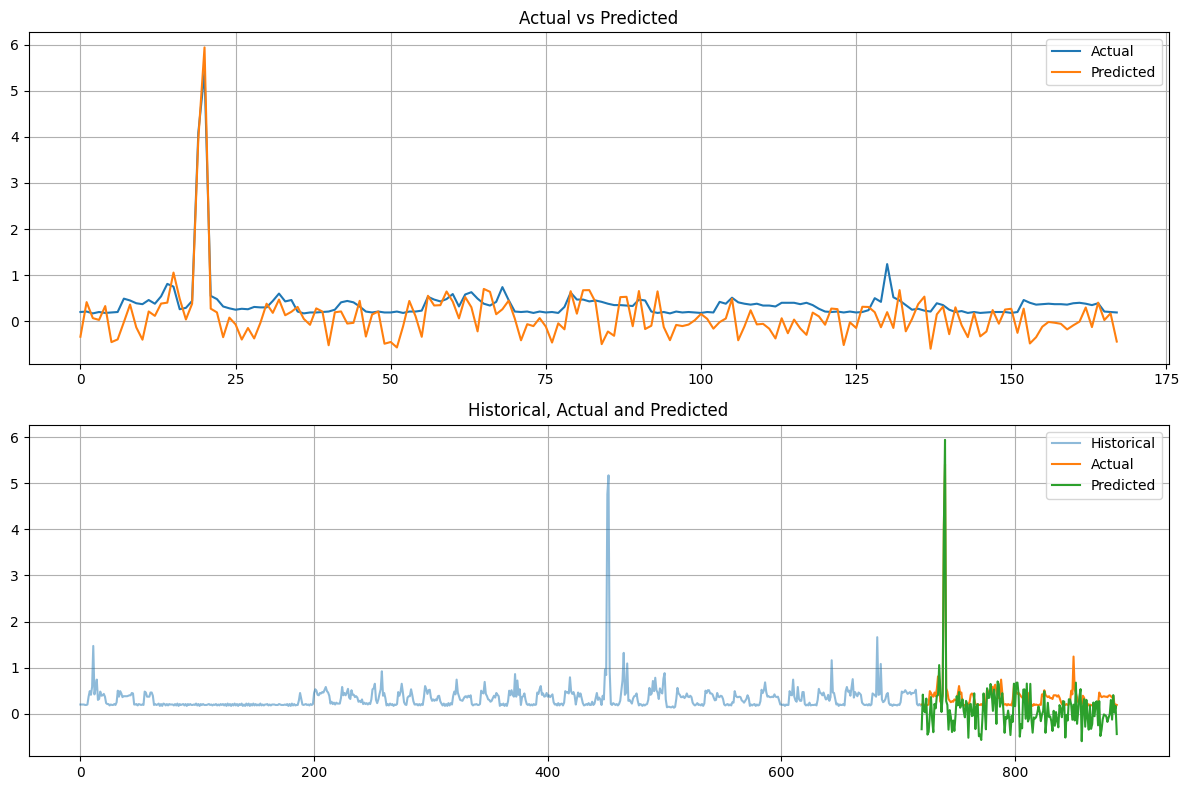


Actual vs Predicted Values:
     Actual  Predicted
0      0.20  -0.335903
1      0.21   0.414346
2      0.17   0.067085
3      0.20   0.028717
4      0.18   0.328732
5      0.19  -0.453288
6      0.20  -0.394512
7      0.49  -0.020334
8      0.45   0.361793
9      0.39  -0.132694
10     0.37  -0.400234
11     0.46   0.211640
12     0.38   0.116236
13     0.54   0.383130
14     0.81   0.402763
15     0.75   1.055416
16     0.26   0.485990
17     0.29   0.038308
18     0.44   0.380449
19     4.09   3.956523
20     5.41   5.938509
21     0.55   0.272727
22     0.48   0.191663
23     0.32  -0.346053
24     0.28   0.078395
25     0.25  -0.068354
26     0.27  -0.396965
27     0.26  -0.146863
28     0.31  -0.373212
29     0.30  -0.036117
30     0.30   0.380316
31     0.44   0.181657
32     0.60   0.470142
33     0.43   0.129656
34     0.46   0.204720
35     0.21   0.310746
36     0.17   0.050902
37     0.19  -0.077444
38     0.19   0.278772
39     0.20   0.209022
40     0.21  -0.521123
41   

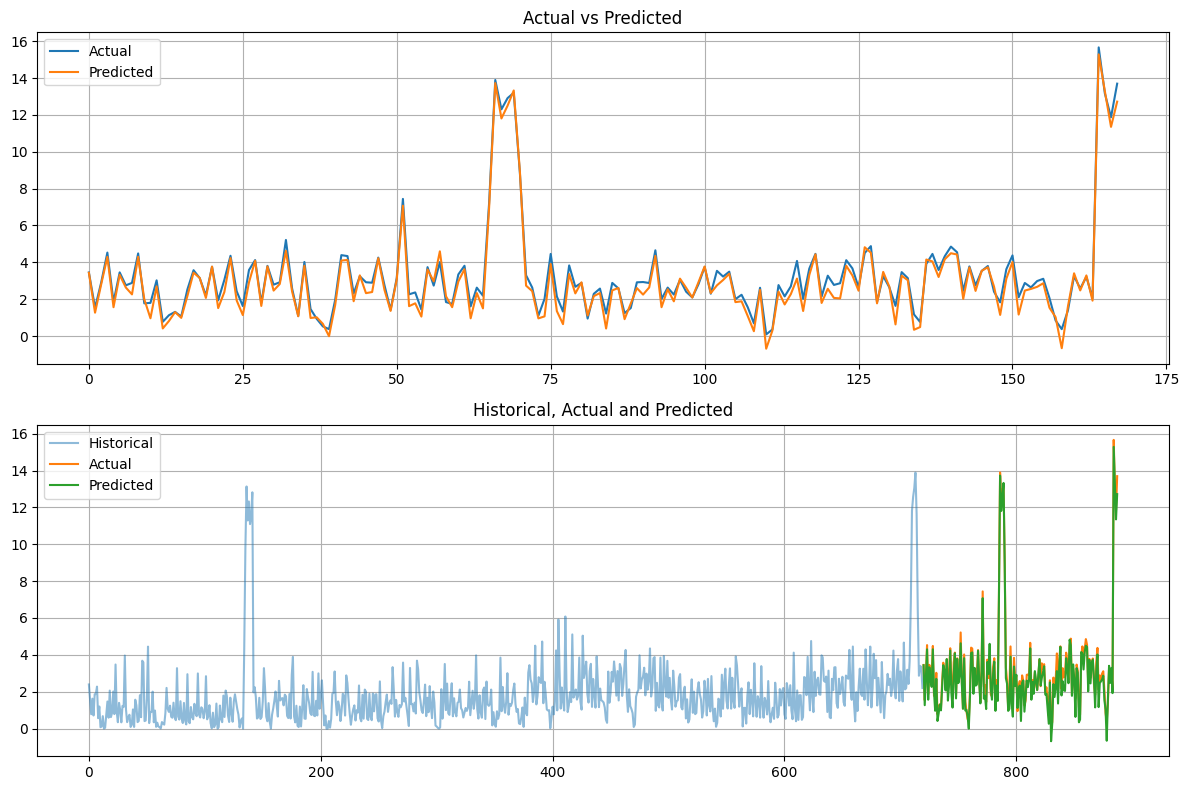


Actual vs Predicted Values:
     Actual  Predicted
0     3.452   3.435506
1     1.538   1.269038
2     2.908   2.810476
3     4.529   4.297650
4     1.859   1.567420
5     3.457   3.321575
6     2.754   2.634534
7     2.885   2.262391
8     4.483   4.301358
9     1.776   1.994255
10    1.802   0.966922
11    3.025   2.699121
12    0.774   0.414390
13    1.132   0.816806
14    1.314   1.300823
15    1.061   0.988984
16    2.532   2.175056
17    3.574   3.441471
18    3.146   3.154989
19    2.202   2.070114
20    3.761   3.770905
21    1.941   1.518459
22    3.049   2.387953
23    4.358   4.234331
24    2.433   1.934127
25    1.629   1.139765
26    3.584   2.914748
27    4.123   4.088555
28    1.794   1.636676
29    3.810   3.779762
30    2.790   2.468378
31    2.919   2.825337
32    5.215   4.625940
33    2.588   2.423659
34    1.090   1.072905
35    4.021   3.816450
36    1.468   0.982909
37    0.936   1.019782
38    0.526   0.663094
39    0.378  -0.006606
40    1.967   1.684352
41   

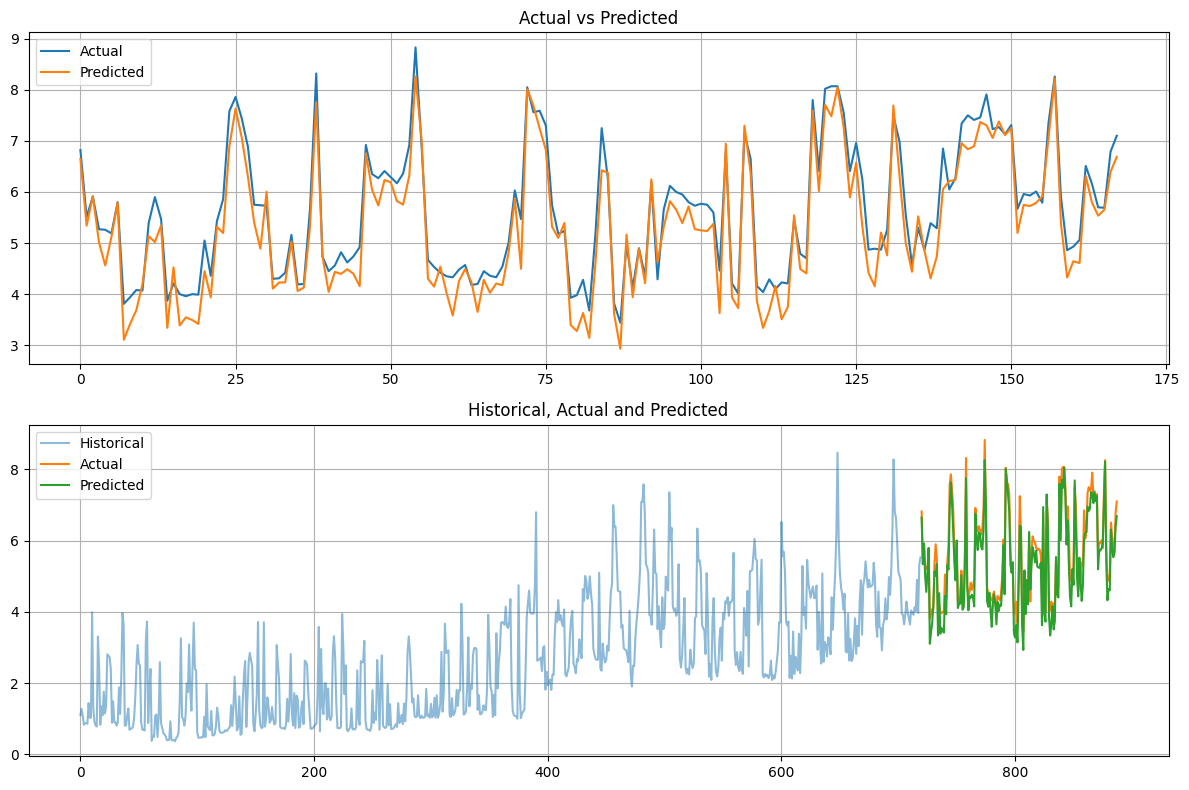


Actual vs Predicted Values:
     Actual  Predicted
0      6.82   6.647515
1      5.51   5.341851
2      5.91   5.919921
3      5.27   5.009317
4      5.26   4.562048
5      5.19   5.120103
6      5.80   5.790814
7      3.81   3.106501
8      3.94   3.417619
9      4.08   3.683014
10     4.07   4.196186
11     5.39   5.135442
12     5.90   5.018417
13     5.47   5.346516
14     3.87   3.341175
15     4.21   4.524334
16     4.00   3.388285
17     3.96   3.545681
18     4.00   3.495298
19     3.99   3.417286
20     5.05   4.450533
21     4.36   3.937881
22     5.43   5.317814
23     5.86   5.196644
24     7.58   6.897123
25     7.86   7.633360
26     7.44   7.063684
27     6.88   6.294272
28     5.75   5.399793
29     5.74   4.888360
30     5.73   6.004883
31     4.30   4.108602
32     4.31   4.226775
33     4.42   4.231218
34     5.16   5.030175
35     4.19   4.061600
36     4.20   4.128129
37     5.67   5.328488
38     8.32   7.757598
39     4.74   4.743895
40     4.45   4.045090
41   

In [4]:
for location in customer_locs:
    print(f"\nProcessing {location}:")
    inference_func(location)